## 1. Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

## 2. Librerias

In [2]:
import numpy as np
import cv2
print(f"OpenCV Version: {cv2.__version__}")
import pandas as pd
import tensorflow as tf
print(f'TensorFlow Version : {tf.__version__}')
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow import keras

OpenCV Version: 4.1.2
TensorFlow Version : 2.7.0


## 3. Inicialización de los datos

In [3]:
tfrec_folder = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/data_files/data/"
csv_folder = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/data_files/"

Reading CSV:

In [4]:
csv_columns = ["path_name","No Finding","Atelectasis","Consolidation","Infiltration","Pneumothorax","Edema","Emphysema","Fibrosis","Effusion","Pneumonia","Pleural_Thickening","Cardiomegaly","Nodule","Mass","Hernia"]
data_csv = pd.read_csv(csv_folder+"preprocessed_data.csv",skiprows=[0], header = None, names = csv_columns)
data_csv.head()

,path_name,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,../input/data/images_001/images/00000001_000.png,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,../input/data/images_001/images/00000001_001.png,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,../input/data/images_001/images/00000001_002.png,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
3,../input/data/images_001/images/00000002_000.png,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,../input/data/images_001/images/00000003_000.png,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [5]:
len(data_csv)

112120

El siguiente feature_map ayuda a descomponer cada una de los samples del TREC (imagenes) en informacion importante de cada uno de ellos:

In [6]:
feature_map = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_id': tf.io.FixedLenFeature([], tf.string),
    'No Finding': tf.io.FixedLenFeature([], tf.int64),
    'Atelectasis': tf.io.FixedLenFeature([], tf.int64),
    'Consolidation': tf.io.FixedLenFeature([], tf.int64),
    'Infiltration': tf.io.FixedLenFeature([], tf.int64),
    'Pneumothorax': tf.io.FixedLenFeature([], tf.int64),
    'Edema': tf.io.FixedLenFeature([], tf.int64),
    'Emphysema': tf.io.FixedLenFeature([], tf.int64),
    'Fibrosis': tf.io.FixedLenFeature([], tf.int64),
    'Effusion': tf.io.FixedLenFeature([], tf.int64),
    'Pneumonia': tf.io.FixedLenFeature([], tf.int64),
    'Pleural_Thickening': tf.io.FixedLenFeature([], tf.int64),
    'Cardiomegaly': tf.io.FixedLenFeature([], tf.int64),
    'Nodule': tf.io.FixedLenFeature([], tf.int64),
    'Mass': tf.io.FixedLenFeature([], tf.int64),
    'Hernia': tf.io.FixedLenFeature([], tf.int64)
}

## 4. Creating Datasets

La siguiente función permite preprocesar una determinada imagen y devolverla junto con su label (enfermedad toracica)


In [7]:
def image_decoder(data,resize_shape = (150,150)):
    example = tf.io.parse_single_example(data, feature_map) 
    image = example['image']
    image = tf.io.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, resize_shape[0], resize_shape[1])
    image.set_shape(resize_shape+(3,))
    image = tf.cast(image, tf.float32) / 255.0
    
    print([label for label in sorted(list(example.keys())) if label!='image' and label!='image_id'])
    labels = [tf.cast(example[x], tf.float32) for x in sorted(list(example.keys())) if x!='image_id' and x!='image']
    
    return image, labels
    

La siguiente funcion es capaz de crear un `TensorFlow Dataset` desde un archivo TF Record.
La salida va a ser un ``prefetchDataset`` lo cual permite realizar el preprocesamiento de los datos a la vez que entrenamiento de TF para no bloquear el disco disponible con demasiado I/O.
Vemos como el numero de datos spobre los que se realiza el preset esta puesto como AUTOTUNE. Esto lo que hará es cambiar el numero de datos que se sacan del buffer dinamicamente en base al entrenamiento dependiendo de cuantos datos por batch necesite este.
Info importante sobre esto: https://www.tensorflow.org/guide/data_performance#prefetching

In [8]:
def tfr_decoder(path, shuffle=True, train_percent=0.8, validate_percent=0.1):

    data_list = [os.path.join(tfrec_folder,x) for x in os.listdir(path)]
    train_end = int(len(data_list)*train_percent) 
    val_end = train_end + int(len(data_list)*validate_percent)
    train_data, val_data, test_data = data_list[:train_end], data_list[train_end:val_end], data_list[val_end:]
    
    trainds = tf.data.TFRecordDataset(train_data)
    trainds = trainds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    valds = tf.data.TFRecordDataset(val_data)
    valds = valds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    testds = tf.data.TFRecordDataset(test_data)
    testds = testds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if shuffle:
        trainds = trainds.shuffle(1024)
        
    trainds = trainds.batch(128).prefetch(tf.data.experimental.AUTOTUNE)
    valds = valds.batch(128).prefetch(tf.data.experimental.AUTOTUNE)
    testds = testds.batch(128).prefetch(tf.data.experimental.AUTOTUNE)
    return trainds, valds, testds

Creamos los datasets de **Train y Validation**


In [9]:
train_ds, val_ds, test_ds = tfr_decoder(tfrec_folder)
print(type(train_ds))
print(train_ds)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<PrefetchDataset shapes: ((None, 150, 150, 3), (None, 15)), types: (tf.float32, tf.float32)>


## 5. Showing datasets images

In [10]:
class_names_list = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

Visualizamos algunas imagenes

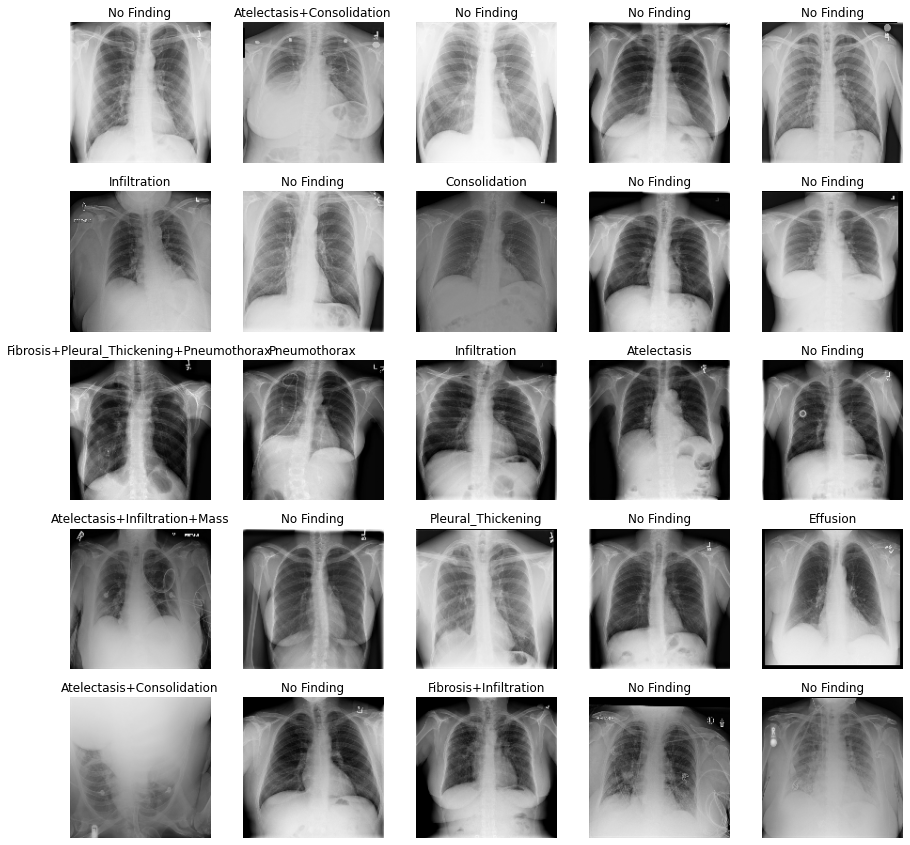

In [12]:
image_viz, label_viz = next(iter(train_ds))

def show_batch(X, Y):
    plt.figure(figsize=(15, 15))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(X[n])
        
        result = [x for i, x in enumerate(class_names_list) if Y[n][i]]
        title = "+".join(result)

        plt.title(title)
        plt.axis("off")

show_batch(image_viz.numpy(), label_viz.numpy())

## 6. Modelos

### 6.1 Baseline Model

Vamos a implementar una red muy sencilla que nos sirva de punto de partida para mejorar siempre a partir de este punto.

#### 6.1.1 Construccion del modelo
La ultima capa queremos que tenga 15 neuronas ( `out_shape = len(class_names_list)` ) y una activacion activacion `sigmoid` para que la salida de la red sean probabilidades para cada una de las patologías.

In [ ]:
image_size = (150,150)
out_shape = len(class_names_list)

In [ ]:
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')


# --------- IMAGE MODEL ---------

# Conv 1
conv_1 = layers.Conv2D(32, (3,3), activation='relu', padding='same', 
                       name='conv_1')(inputs)
pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)

# Conv 2
conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same', 
                       name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)



# --------- CLASSIFICATION MODEL ---------

flat = layers.Flatten(name='flatten')(pool_2)
dense = layers.Dense(128, activation='relu', name='dense')(flat)
outputs = layers.Dense(15, activation='sigmoid', name = "output")(dense)



In [ ]:
baseline_model = keras.Model(inputs = inputs, outputs = outputs, name = "baseline_model")
baseline_model.summary()


Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 pool_1 (MaxPooling2D)       (None, 75, 75, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 75, 75, 64)        18496     
                                                                 
 pool_2 (MaxPooling2D)       (None, 37, 37, 64)        0         
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 128)            

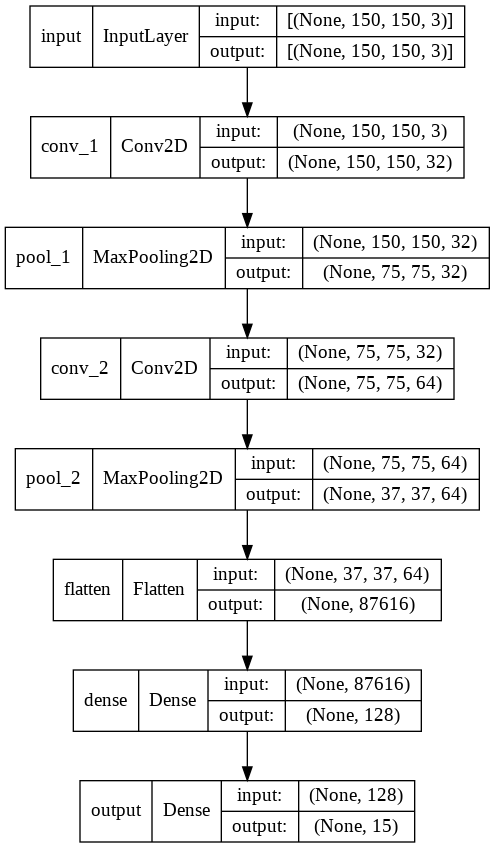

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(baseline_model, show_shapes=True)

#### 6.1.2 Entrenamiento y validación del modelo

In [ ]:
baseline_model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=[tf.keras.metrics.AUC(multi_label=True),'binary_accuracy'])

In [ ]:
import time
start = time.time()
history = baseline_model.fit(train_ds, 
                             epochs=3,
                             validation_data = val_ds)
end = time.time()
train_time = {}
train_time["baseline_model"] = (end-start)/60
print(str(train_time["baseline_model"]) + " minutos tardó en entrenar")

Epoch 1/3
699/699 [==============================] - 443s 614ms/step - loss: 0.2134 - auc: 0.5998 - binary_accuracy: 0.9258 - val_loss: 0.2103 - val_auc: 0.6611 - val_binary_accuracy: 0.9242
Epoch 2/3
699/699 [==============================] - 444s 628ms/step - loss: 0.2036 - auc: 0.6647 - binary_accuracy: 0.9280 - val_loss: 0.2053 - val_auc: 0.6775 - val_binary_accuracy: 0.9286
Epoch 3/3
699/699 [==============================] - 516s 732ms/step - loss: 0.1988 - auc: 0.7042 - binary_accuracy: 0.9290 - val_loss: 0.2005 - val_auc: 0.6900 - val_binary_accuracy: 0.9287
1615237060.171546 minutos tardó en entrenar


Guardamos el modelo:

In [ ]:
path_to_models = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/modelos/"
model_name = "baseline_model.h5"

In [ ]:
#baseline_model.save(path_to_models+model_name)

In [ ]:
baseline_model = keras.models.load_model(path_to_models+model_name)

Una vez entrenado podemos evaluar como se comporta con datos del dataset de validación:

In [ ]:
test_loss, test_auc, test_accuracy = baseline_model.evaluate(test_ds)

print('test_loss, test_auc, test_accuracy:', test_loss, test_auc, test_accuracy)

93/93 [==============================] - 27s 284ms/step - loss: 0.2021 - auc: 0.6838 - binary_accuracy: 0.9287
test_loss, test_auc, test_accuracy: [0.20213624835014343, 0.6837664246559143, 0.9287190437316895]


Podemos plotear la funcion de perdida asi como la AUC en el dataset de validación (NOT WORKING YET)

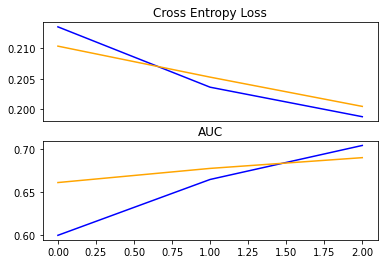

In [ ]:
#Plot loss
ax = plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
ax.axes.xaxis.set_visible(False)

# plot accuracy
plt.subplot(212)
plt.title('AUC')
plt.plot(history.history['auc'], color='blue', label='train')
plt.plot(history.history['val_auc'], color='orange', label='validation')